In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [8]:
dataset = pd.read_csv('ratings.csv')
dataset['movieId'].nunique()

9066

In [9]:
dataset.size

400016

In [30]:
sparsity = dataset.size/(dataset['movieId'].nunique() * dataset['userId'].nunique())

In [31]:
print(sparsity)

0.0657565664347


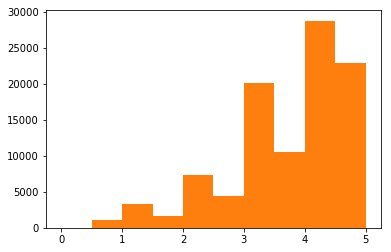

In [18]:
plt.hist(dataset['rating'],bins=np.arange(0, 5 + 0.5, 0.5))
plt.show()

In [26]:
movie_ids = dataset['movieId']
unique_elements, counts_elements = np.unique(movie_ids, return_counts=True)

In [34]:
dictionary = dict(zip(counts_elements,unique_elements))